In [2]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/human-stress-prediction/Stress.csv


In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import gensim.downloader as api
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import spacy
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from collections import Counter
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam


# **Importing data**

In [4]:
stress_data_path ='../input/human-stress-prediction/Stress.csv'
stress_data = pd.read_csv(stress_data_path)

# Exploratory Data Analysis

In [7]:
print("First rows of the dataset: \n")
print(stress_data.head())

First rows of the dataset: 

          subreddit post_id sentence_range  \
0              ptsd  8601tu       (15, 20)   
1        assistance  8lbrx9         (0, 5)   
2              ptsd  9ch1zh       (15, 20)   
3     relationships  7rorpp        [5, 10]   
4  survivorsofabuse  9p2gbc         [0, 5]   

                                                text  label  confidence  \
0  He said he had not felt that way before, sugge...      1         0.8   
1  Hey there r/assistance, Not sure if this is th...      0         1.0   
2  My mom then hit me with the newspaper and it s...      1         0.8   
3  until i met my new boyfriend, he is amazing, h...      1         0.6   
4  October is Domestic Violence Awareness Month a...      1         0.8   

   social_timestamp  
0        1521614353  
1        1527009817  
2        1535935605  
3        1516429555  
4        1539809005  


In [8]:
print("Example post in the dataset: \n")
print(stress_data['text'].iloc[128])

Example post in the dataset: 

(I should note, our first year together we went to the Maldives, second year we bought a house & went to Croatia, Venice, Belgium, Lots of weekends away - I'm not exactly lacking trips away) *I'm content and rarely feel unhappy these days, but is that a replacement of happiness? * Is this just a January blues thing that will go as the year starts moving on and I get back into the swing of things? ---


In [5]:
# Basic statistics in terms of characters
post_char_lengths = stress_data.text.apply(len)
print("\nBasic statistics of post lengths (in characters): \n")
char_statistics = post_char_lengths.describe()
print(char_statistics)

# Calculate the length of each post in terms of words
stress_data['word_length'] = stress_data['text'].apply(lambda post: len(post.split())) # Store to new column
post_word_lengths = stress_data['word_length']
print("\nBasic statistics of post lengths (in words): \n")
word_statistics = post_word_lengths.describe()
print(word_statistics)



Basic statistics of post lengths (in characters): 

count    2838.000000
mean      447.996476
std       168.929122
min         6.000000
25%       339.000000
50%       421.000000
75%       528.750000
max      1639.000000
Name: text, dtype: float64

Basic statistics of post lengths (in words): 

count    2838.000000
mean       85.669838
std        32.292305
min         1.000000
25%        65.000000
50%        80.000000
75%       101.000000
max       310.000000
Name: word_length, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


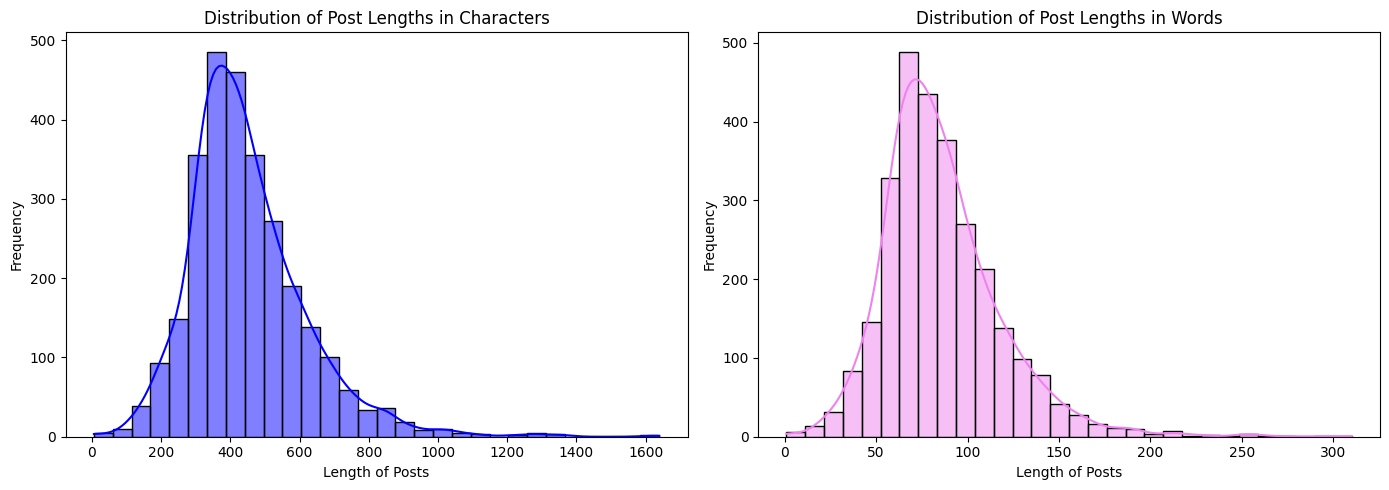

In [79]:
plt.figure(figsize=(14, 5))

# Distribution of post lengths in words
plt.subplot(1, 2, 1)
sns.histplot(post_char_lengths, kde=True, bins=30, color='blue')
plt.title('Distribution of Post Lengths in Characters')
plt.xlabel('Length of Posts')
plt.ylabel('Frequency')

# Distribution of post lengths in characters
plt.subplot(1, 2, 2)
sns.histplot(post_word_lengths, kde=True, bins=30, color='violet')
plt.title('Distribution of Post Lengths in Words')
plt.xlabel('Length of Posts')
plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()


*We can observe that the most posts range in length from 200 to 800 in characters, or 50 to 150 in words.*

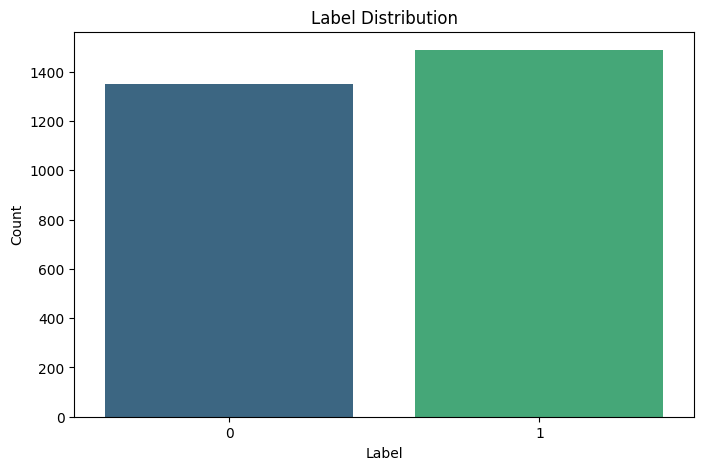

In [80]:
# Label distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=stress_data, palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

*We can observe that the dataset is balanced, with respect to the class we want to predict.*

# Removing detected outliers


Number of outliers below lower bound (Q1 - 1.5 * IQR): 6
Number of outliers above upper bound (Q3 + 1.5 * IQR): 87
Lower bound (Q1 - 1.5 * IQR): 11.0, Upper bound (Q3 + 1.5 * IQR): 155.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


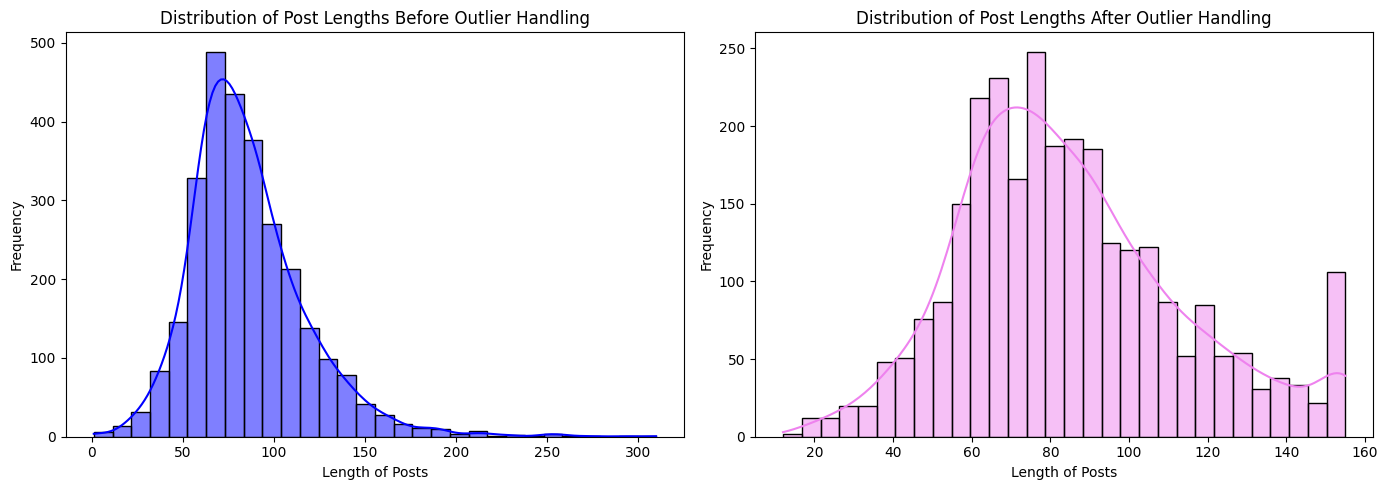

In [6]:
# Calculate interquartile range (IQR)
Q1 = word_statistics['25%']
Q3 = word_statistics['75%']
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a copy of the original DataFrame
filtered_data = stress_data.copy()

# Iterate through each row
for index, row in filtered_data.iterrows():
    if row['word_length'] > upper_bound:
        # Truncate posts longer than upper_bound
        filtered_data.at[index, 'text'] = ' '.join(row['text'].split()[:int(upper_bound)])

# Remove posts below lower bound
filtered_data = filtered_data[filtered_data['word_length'] >= lower_bound]

# Print information about outliers
outliers_below = stress_data[stress_data['word_length'] < lower_bound]
outliers_above = stress_data[(stress_data['word_length'] > upper_bound)]
print(f"\nNumber of outliers below lower bound (Q1 - 1.5 * IQR): {outliers_below.shape[0]}")
print(f"Number of outliers above upper bound (Q3 + 1.5 * IQR): {outliers_above.shape[0]}")
print(f"Lower bound (Q1 - 1.5 * IQR): {lower_bound}, Upper bound (Q3 + 1.5 * IQR): {upper_bound}")

# Plot the distribution of post lengths before and after removing outliers
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(stress_data['word_length'], kde=True, bins=30, color='blue')
plt.title('Distribution of Post Lengths Before Outlier Handling')
plt.xlabel('Length of Posts')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(filtered_data['text'].apply(lambda x: len(x.split())), kde=True, bins=30, color='violet')
plt.title('Distribution of Post Lengths After Outlier Handling')
plt.xlabel('Length of Posts')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


*We can observe that we achieved a better distribution of post's lengths in terms of words by removing lower outliers and truncating upper outliers.*

**Comment**

*I decided not to use the dataset with removed/truncated outliers as it did not make much of a difference towards the accuracy.*

In [28]:
stress_data

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,word_length
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353,113
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817,108
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605,166
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555,273
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005,89
...,...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044,92
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412,135
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312,135
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143,68


In [6]:
filtered_data

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,word_length
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.800000,1521614353,113
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.000000,1527009817,108
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.800000,1535935605,166
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.600000,1516429555,273
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.800000,1539809005,89
...,...,...,...,...,...,...,...,...
2833,relationships,7oee1t,"[35, 40]","* Her, a week ago: Precious, how are you? (I i...",0,1.000000,1515187044,92
2834,ptsd,9p4ung,"[20, 25]",I don't have the ability to cope with it anymo...,1,1.000000,1539827412,135
2835,anxiety,9nam6l,"(5, 10)",In case this is the first time you're reading ...,0,1.000000,1539269312,135
2836,almosthomeless,5y53ya,"[5, 10]",Do you find this normal? They have a good rela...,0,0.571429,1488938143,68


# **Text Preprocessing**

In [7]:
posts = stress_data['text'].tolist()  # Extract the 'posts' column as a list
labels = stress_data['label'].tolist()  # Extract the 'labels' column as a list
posts_filtered = filtered_data['text'].tolist()  # Extract the 'posts' column as a list
labels_filtered = filtered_data['label'].tolist()  # Extract the 'labels' column as a list

# Combine the two lists into a list of tuples
data = list(zip(posts, labels))
data_filtered = list(zip(posts_filtered, labels_filtered))

In [8]:
nlp = spacy.load("en_core_web_lg")

In [11]:
def preprocess(post):
    doc = nlp(post)  # Fit the spaCy model
    
    clean_tokens = []
    for token in doc:
        # Skip punctuation, stopwords, and tokens containing non-alphabetic characters
        if token.is_punct or token.is_stop or not token.text.isalpha():
            continue
        clean_tokens.append(token.lemma_) #Else append lemmatized version of the word
    
    return clean_tokens

In [104]:
data[0]

('He said he had not felt that way before, suggeted I go rest and so ..TRIGGER AHEAD IF YOUI\'RE A HYPOCONDRIAC LIKE ME: i decide to look up "feelings of doom" in hopes of maybe getting sucked into some rabbit hole of ludicrous conspiracy, a stupid "are you psychic" test or new age b.s., something I could even laugh at down the road. No, I ended up reading that this sense of doom can be indicative of various health ailments; one of which I am prone to.. So on top of my "doom" to my gloom..I am now f\'n worried about my heart. I do happen to have a physical in 48 hours.',
 1)

In [12]:
tokenized_data = []
label_data = []
for post,label in data: 
    tokenized_post = preprocess(post)
    if tokenized_post:
        tokenized_data.append(tokenized_post)
        label_data.append(label)


In [35]:
len(label_data)

2832

# Data Visualization

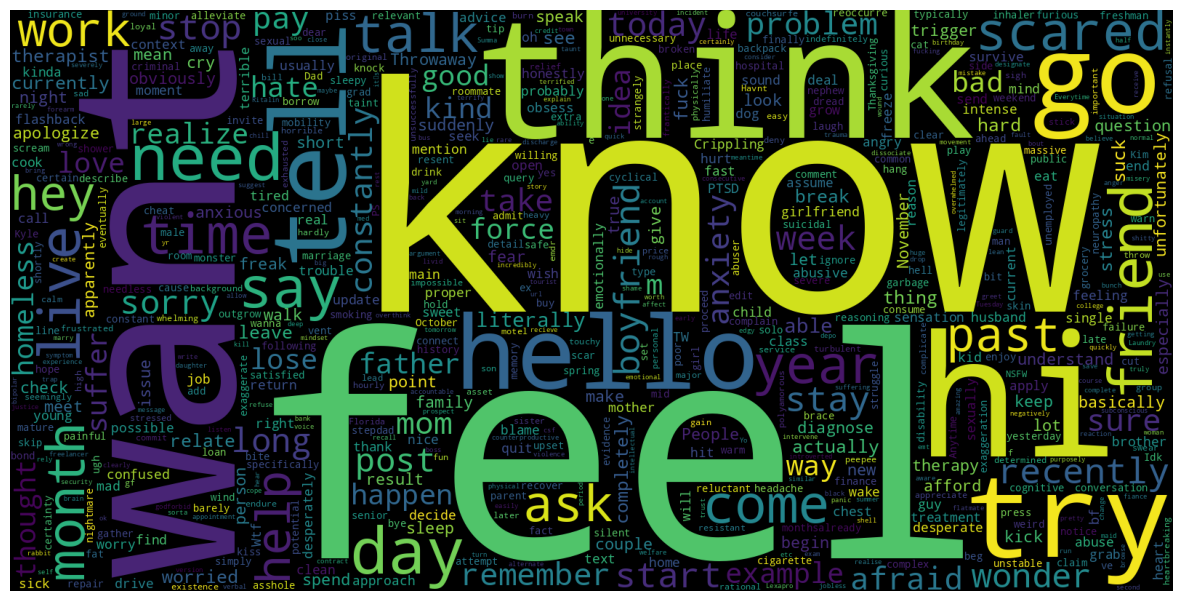

In [107]:
# Extract input texts with label 1
input_texts = [data[0] for data, label in zip(tokenized_data, label_data) if label == 1]  #Traverse the list as list of tuples 

# Generate word cloud
wordcloud = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join(input_texts)) #Join strings into one 

# Plot word cloud
plt.figure(figsize=(15, 15)) 
plt.imshow(wordcloud)
plt.axis('off')  # Remove axis
plt.show()



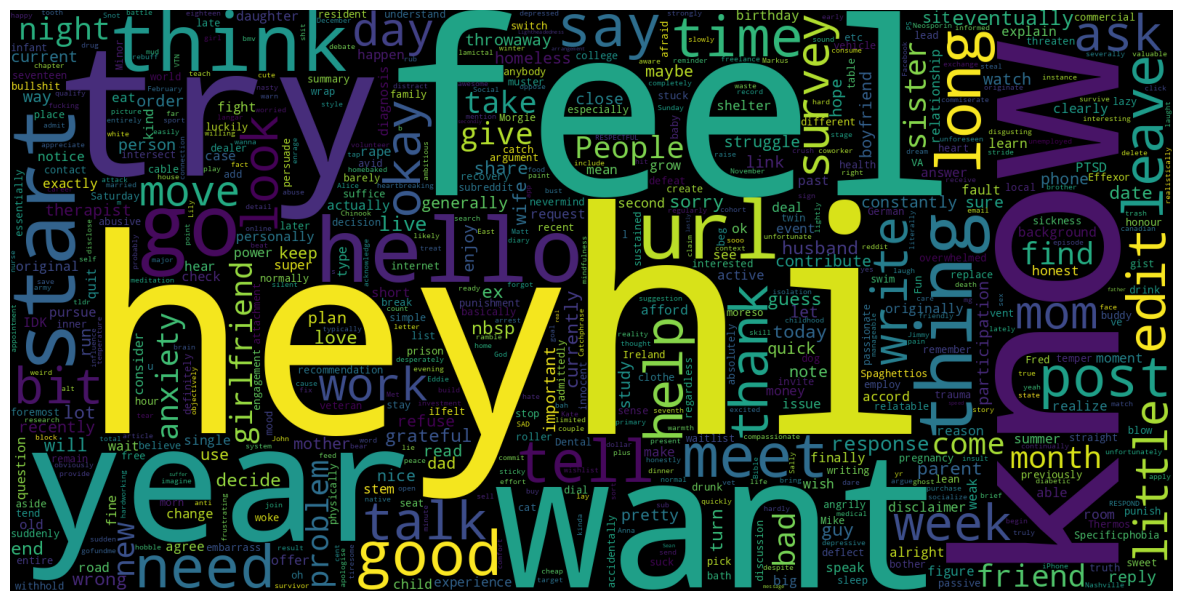

In [108]:
# Extract input texts with label 0
input_texts = [data[0] for data, label in zip(tokenized_data, label_data) if label == 0]

# Generate word cloud
wordcloud = WordCloud(max_words=2000, width=1600, height=800).generate(' '.join(input_texts))

# Plot word cloud
plt.figure(figsize=(15, 15)) 
plt.imshow(wordcloud)
plt.axis('off')  # Remove axis
plt.show()


In [29]:
print(tokenized_data[0])
print(label_data[0])


['say', 'feel', 'way', 'suggete', 'rest', 'TRIGGER', 'AHEAD', 'HYPOCONDRIAC', 'like', 'decide', 'look', 'feeling', 'doom', 'hope', 'maybe', 'getting', 'suck', 'rabbit', 'hole', 'ludicrous', 'conspiracy', 'stupid', 'psychic', 'test', 'new', 'age', 'laugh', 'road', 'end', 'read', 'sense', 'doom', 'indicative', 'health', 'ailment', 'prone', 'doom', 'gloom', 'worried', 'heart', 'happen', 'physical', 'hour']
1


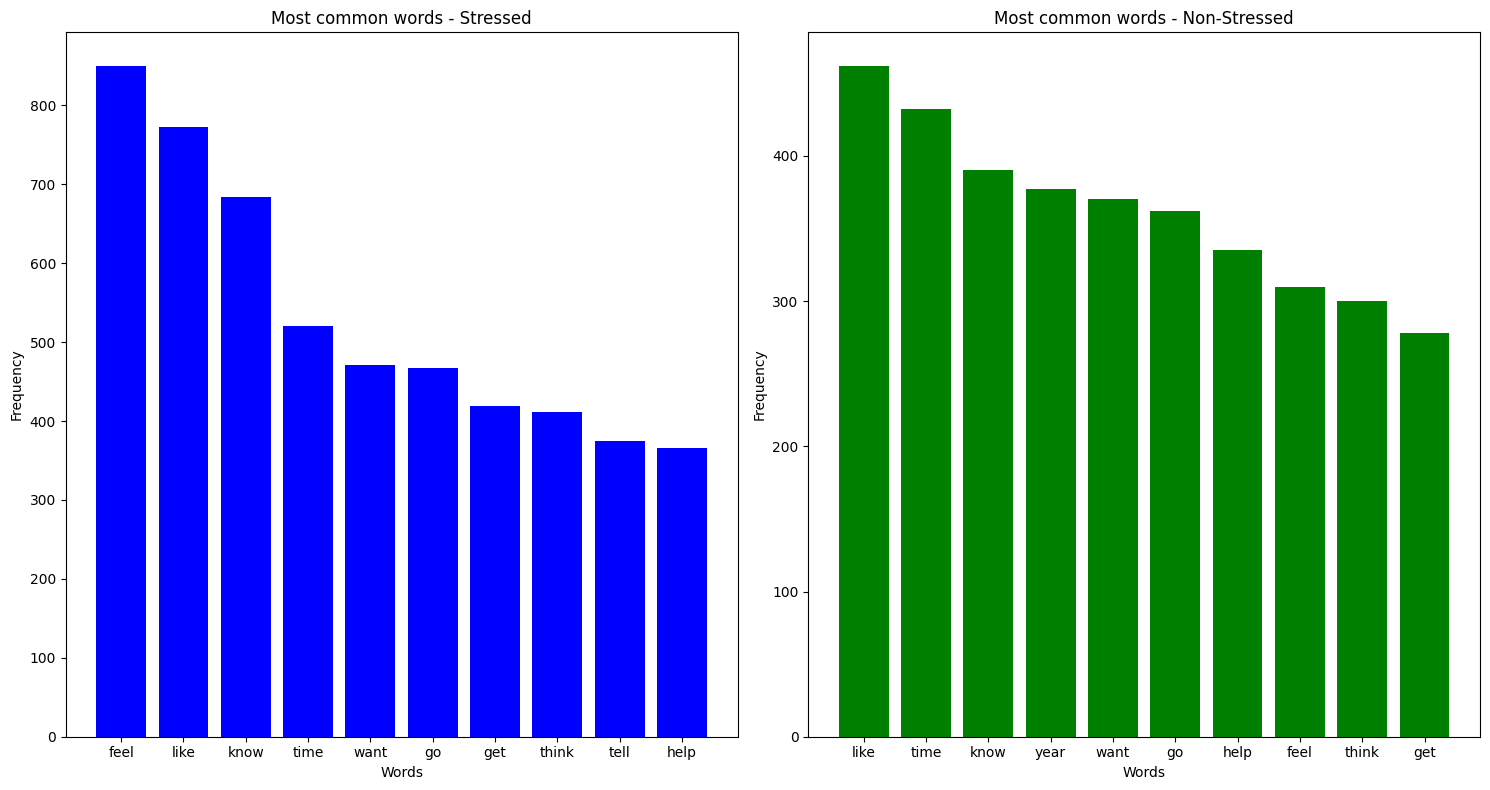

In [35]:
# Extract input texts with label 1 and label 0
input_texts_label1 = [' '.join(data) for data, label in zip(tokenized_data, label_data) if label == 1]
input_texts_label0 = [' '.join(data) for data, label in zip(tokenized_data, label_data) if label == 0]

# Function to get top n most common words
def get_top_words(texts, n=10):
    words = ' '.join(texts).split()
    word_counts = Counter(words)
    top_words = word_counts.most_common(n)
    return top_words

# Get top 10 words for each label
top_words_label1 = get_top_words(input_texts_label1)
top_words_label0 = get_top_words(input_texts_label0)

# Plotting side by side
plt.figure(figsize=(15, 8))

# Plot for Label 1 (Stressed)
plt.subplot(1, 2, 1)
words_label1 = [word[0] for word in top_words_label1]
freqs_label1 = [word[1] for word in top_words_label1]
plt.bar(words_label1, freqs_label1, color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most common words - Stressed')

# Plot for Label 0 (Non-Stressed)
plt.subplot(1, 2, 2)
words_label0 = [word[0] for word in top_words_label0]
freqs_label0 = [word[1] for word in top_words_label0]
plt.bar(words_label0, freqs_label0, color='green')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most common words - Non-Stressed')

plt.tight_layout()
plt.show()


*We can see that most common words for each label are pretty similar.*

# **Splitting Data**

In [17]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    tokenized_data, 
    label_data, 
    train_size=0.8, 
    random_state=4
)


print(len(X_test))
print(len(y_test))

567
567


# **Bag of Words**

In [28]:
# Convert tokenized data to strings
X_train_str = [' '.join(doc) for doc in X_train]
X_test_str = [' '.join(doc) for doc in X_test]

# Create the TF-IDF vectorizer
tf_vectorizer = TfidfVectorizer(min_df=0, max_df=1, use_idf=True, ngram_range=(1, 1))

# Tokenize and build vocabulary on the training data
bow_train = tf_vectorizer.fit_transform(X_train_str)

# Encode the test data using the same vocabulary
bow_test = tf_vectorizer.transform(X_test_str)

# Print the dimensions of the TF-IDF matrices
print('BOW train shape:', bow_train.shape)
print('BOW test shape:', bow_test.shape)


BOW train shape: (2267, 3607)
BOW test shape: (567, 3607)


In [29]:
print("Example entry in bow_train:")
print(bow_train[0].toarray)  

Example entry in bow_train:
<bound method _cs_matrix.toarray of <1x3607 sparse matrix of type '<class 'numpy.float64'>'
	with 0 stored elements in Compressed Sparse Row format>>


# **Bag of N-Grams**

In [30]:
# create the transform
tf_vectorizer2 = TfidfVectorizer(analyzer='word', ngram_range=(1, 3)) #instead of separate words treat them as 7-grams, groups of len 7
# tokenize and build vocab
bon_train = tf_vectorizer2.fit_transform(X_train_str)

# encode document
bon_test = tf_vectorizer2.transform(X_test_str)
# summarize
#print(sorted(vectorizer.vocabulary_))
print('BON train: ',bow_train.shape)
print('BON test: ',bow_test.shape)

BON train:  (2267, 3607)
BON test:  (567, 3607)


In [102]:
print("Example entry in bon_train:")
#print(bon_train[0])  

Example entry in bon_train:


# **Generating embeddings**

In [ ]:
wv = api.load("glove-twitter-25")

[=============================---------------------] 59.9% 62.8/104.8MB downloaded

In [18]:
wv.get_mean_vector(X_train[2]) #Example post as vector average of words that comprise it

array([-0.07963082,  0.02786993, -0.1118979 ,  0.07432982,  0.06536698,
        0.00142367,  0.09981715, -0.21375556,  0.06222064,  0.04254569,
        0.02311464,  0.09475099, -0.5490071 ,  0.01281391,  0.07900295,
        0.06116072,  0.04513504,  0.00119624,  0.04749446, -0.08894351,
       -0.07666157,  0.10886507,  0.12574716, -0.00554666, -0.09551053],
      dtype=float32)

In [135]:
len(wv.get_vector(X_train[2][0])) #Dimensionality of one word

25

In [25]:
wv_train_data = []
for tokenized_post in X_train:
    if tokenized_post:  #some may be empty bcs of stopword removal
        wv_train_data.append(wv.get_mean_vector(tokenized_post)) #get mean vector embedding for every post


# **Naive Bayes**


In [31]:
# Initialize Gaussian Naive Bayes models
gnb_bow = GaussianNB()
gnb_bon = GaussianNB()
gnb_w2v = GaussianNB()

# Fit and evaluate GNB on BOW
gnb_bow.fit(bow_train.toarray(), y_train)
y_pred_bow = gnb_bow.predict(bow_test.toarray())
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(f"Accuracy of Gaussian NB on BOW: {accuracy_bow:.4f}")

# Fit and evaluate GNB on BON
gnb_bon.fit(bon_train.toarray(), y_train)
y_pred_bon = gnb_bon.predict(bon_test.toarray())
accuracy_bon = accuracy_score(y_test, y_pred_bon)
print(f"Accuracy of Gaussian NB on BON: {accuracy_bon:.4f}")

# Prepare Word2Vec representations for training and test data
wv_train_data = []
for tokenized_post in X_train:
    if tokenized_post:  # Ensure the post has tokens after stopword removal
        wv_train_data.append(wv.get_mean_vector(tokenized_post))  # Average vectors for each post

wv_test_data = []
for tokenized_post in X_test:
    if tokenized_post:  # Ensure the post has tokens after stopword removal
        wv_test_data.append(wv.get_mean_vector(tokenized_post))  # Average vectors for each post

# Fit and evaluate GNB on Word2Vec
gnb_w2v.fit(wv_train_data, y_train)
y_pred_w2v = gnb_w2v.predict(wv_test_data)
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
print(f"Accuracy of Gaussian NB on Word2Vec: {accuracy_w2v:.4f}")


Accuracy of Gaussian NB on BOW: 0.5591
Accuracy of Gaussian NB on BON: 0.6314
Accuracy of Gaussian NB on Word2Vec: 0.6931


# Logistic Regression

In [32]:
# Initialize Logistic Regression model
logreg_bow = LogisticRegression(max_iter=1000, random_state=4)

# Fit and evaluate Logistic Regression on BOW
logreg_bow.fit(bow_train, y_train)
y_pred_bow = logreg_bow.predict(bow_test)
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(f"Accuracy of Logistic Regression on BOW: {accuracy_bow:.4f}")

# Initialize Logistic Regression model
logreg_bon = LogisticRegression(max_iter=1000, random_state=4)

# Fit and evaluate Logistic Regression on BON
logreg_bon.fit(bon_train, y_train)
y_pred_bon = logreg_bon.predict(bon_test)
accuracy_bon = accuracy_score(y_test, y_pred_bon)
print(f"Accuracy of Logistic Regression on BON: {accuracy_bon:.4f}")

# Initialize Logistic Regression model
logreg_w2v = LogisticRegression(max_iter=1000, random_state=4)

# Fit and evaluate Logistic Regression on Word2Vec (average vectors)
logreg_w2v.fit(wv_train_data, y_train)
y_pred_w2v = logreg_w2v.predict(wv_test_data)
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
print(f"Accuracy of Logistic Regression on Word2Vec: {accuracy_w2v:.4f}")

Accuracy of Logistic Regression on BOW: 0.5608
Accuracy of Logistic Regression on BON: 0.6984
Accuracy of Logistic Regression on Word2Vec: 0.7002


# Support Vector Machine

In [33]:
# Initialize SVM model
svm_bow = SVC(kernel='linear', random_state=4)

# Fit and evaluate SVM on BOW
svm_bow.fit(bow_train, y_train)
y_pred_bow = svm_bow.predict(bow_test)
accuracy_bow = accuracy_score(y_test, y_pred_bow)
print(f"Accuracy of SVM on BOW: {accuracy_bow:.4f}")

# Initialize SVM model
svm_bon = SVC(kernel='linear', random_state=4)

# Fit and evaluate SVM on BON
svm_bon.fit(bon_train, y_train)
y_pred_bon = svm_bon.predict(bon_test)
accuracy_bon = accuracy_score(y_test, y_pred_bon)
print(f"Accuracy of SVM on BON: {accuracy_bon:.4f}")

# Initialize SVM model
svm_w2v = SVC(kernel='rbf', random_state=4) #changed kernel from linear to rbf

# Fit and evaluate SVM on Word2Vec (average vectors)
svm_w2v.fit(wv_train_data, y_train)
y_pred_w2v = svm_w2v.predict(wv_test_data)
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
print(f"Accuracy of SVM on Word2Vec: {accuracy_w2v:.4f}")



Accuracy of SVM on BOW: 0.5626
Accuracy of SVM on BON: 0.7231
Accuracy of SVM on Word2Vec: 0.7002


# LSTM

In [ ]:
# Function to create sequences using W2V model
def create_sequences_and_labels(tokenized_data, labels, wv_model, seq_length, vector_size):
    sequences = []
    sequence_labels = []
    for post, label in zip(tokenized_data, labels):
        if post:  # Ensure the post is not empty
            vectorized_post = []
            for word in post:
                if word in wv_model:
                    vectorized_post.append(wv_model.get_vector(word))
               # else:
                #    vectorized_post.append(np.random.normal(size=vector_size))  # Generate random vector

            for i in range(len(vectorized_post) - seq_length + 1):
                seq = vectorized_post[i:i + seq_length]
                if len(seq) == seq_length:
                    sequences.append(seq)
                    sequence_labels.append(label)

    return np.array(sequences), np.array(sequence_labels)

In [46]:
# Parameters
seq_length = 20
vector_size = 25 

# Create sequences and labels
X_train_lstm, y_train_lstm = create_sequences_and_labels(X_train, y_train, wv, seq_length, vector_size)
X_test_lstm, y_test_lstm = create_sequences_and_labels(X_test, y_test, wv, seq_length, vector_size)

print(f"Shape of X_train_lstm: {X_train_lstm.shape}")
print(f"Shape of y_train_lstm: {y_train_lstm.shape}")
print(f"Shape of X_test_lstm: {X_test_lstm.shape}")
print(f"Shape of y_test_lstm: {y_test_lstm.shape}")


# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, 25), return_sequences=False, kernel_regularizer='l2'))  # Add L2 regularization to prevent overfitting
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_regularizer='l2')) 

adam = Adam(learning_rate=3e-4)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model
model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=128, validation_data=(X_test_lstm, y_test_lstm))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm)
print(f'Accuracy: {accuracy:.4f}')


Shape of X_train_lstm: (27494, 20, 25)
Shape of y_train_lstm: (27494,)
Shape of X_test_lstm: (7457, 20, 25)
Shape of y_test_lstm: (7457,)
Epoch 1/20
215/215 [==============================] - 13s 48ms/step - loss: 0.8988 - accuracy: 0.6349 - val_loss: 0.7220 - val_accuracy: 0.6847
Epoch 2/20
215/215 [==============================] - 10s 45ms/step - loss: 0.6834 - accuracy: 0.6744 - val_loss: 0.6592 - val_accuracy: 0.6595
Epoch 3/20
215/215 [==============================] - 10s 46ms/step - loss: 0.6410 - accuracy: 0.6769 - val_loss: 0.6307 - val_accuracy: 0.6798
Epoch 4/20
215/215 [==============================] - 10s 45ms/step - loss: 0.6244 - accuracy: 0.6805 - val_loss: 0.6301 - val_accuracy: 0.6788
Epoch 5/20
215/215 [==============================] - 10s 44ms/step - loss: 0.6168 - accuracy: 0.6821 - val_loss: 0.6189 - val_accuracy: 0.6815
Epoch 6/20
215/215 [==============================] - 10s 45ms/step - loss: 0.6135 - accuracy: 0.6789 - val_loss: 0.6296 - val_accuracy: 0.678

# Conclusion

*In the evaluation across three different text representation methods—Bag-of-Words (BOW), Bag-of-Ngrams (BON), and Word2Vec—varied performance among different machine learning algorithms was found. Word2Vec consistently outperformed BOW and BON across most classifiers, displaying its effectiveness in capturing semantic relationships in textual data. Surprisingly, SVM yielded the highest accuracy with BON, 72%. However, LSTM, trained on Word2Vec embeddings, demonstrated lower accuracy compared to traditional machine learning models. This suggests that LSTM models may require more fine-tuning of hyperparameters (or another approach of feeding vectors to the algorithm) and potentially more data to achieve better performance, particularly on small datasets like this one.*



